In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
import copy
import os
import pprint

import hydra
from omegaconf import OmegaConf
from einops import rearrange
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy as sa
import seaborn as sns
import lightning.pytorch
import polars as pl
from tqdm import tqdm

from conf import conf
from g_led import datasets, utils

In [3]:
with hydra.initialize(version_base=utils.HYDRA_INIT['version_base'], config_path='../conf'):
    cfg = hydra.compose(utils.HYDRA_INIT['config_name'], overrides=[
        'dataset=KuramotoSivashinsky1D',
        'model=TransformerKuramotoSivashinsky1D',
    ])
    engine = conf.get_engine()
    conf.orm.create_all(engine)
    with conf.sa.orm.Session(engine) as db:
        cfg = conf.orm.instantiate_and_insert_config(db, OmegaConf.to_container(cfg, resolve=True))
        db.commit()
        pprint.pp(cfg.dataset)

KuramotoSivashinsky1D(_data_dir='/mnta/taosData/diffusion-dynamics/G-LED/data',
                      rng_seed=2376999025,
                      _processed_filename='j4y2c6ly',
                      trajectory_count_train=2,
                      trajectory_count_val=1,
                      trajectory_count_test=1,
                      trajectory_time_step_size_micro=0.025,
                      trajectory_time_step_count_micro=3840,
                      trajectory_time_step_subsample_interval_macro=10,
                      macro_time_step_count_train=None,
                      macro_time_step_count_val=None,
                      macro_time_step_count_test=None,
                      time_step_window_size_train=None,
                      time_step_window_size_val=None,
                      time_step_window_size_test=None,
                      batch_size_train=16,
                      batch_size_val=16,
                      batch_size_test=16,
                      id=1,
    

In [4]:
lightning.pytorch.seed_everything(cfg.rng_seed)
with lightning.pytorch.utilities.seed.isolate_rng():
    dataset = datasets.get_dataset(cfg.dataset)

Seed set to 2376999025


In [9]:
dataset.prepare_data()
dataset.setup('fit')
dataset.train.shape

torch.Size([2, 385, 1, 64])

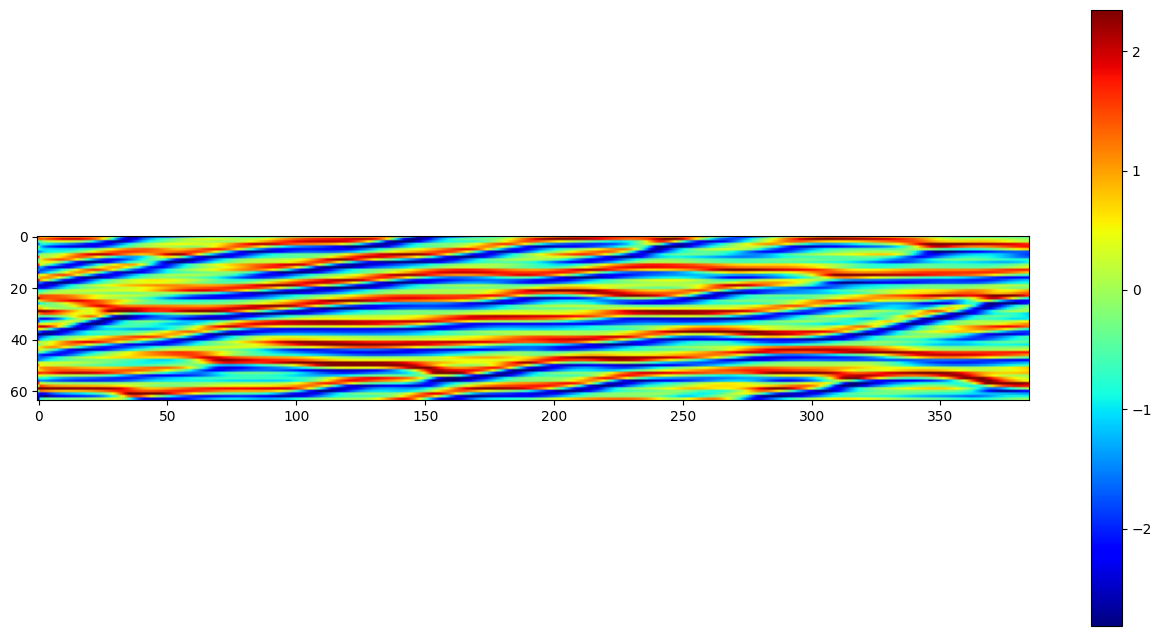

In [10]:
data = rearrange(
    dataset.train[0],
    'time 1 dim -> dim time',
).numpy()
fig, ax = plt.subplots(figsize=(16, 8))
p = .01
im_out = ax.imshow(data, cmap='jet', vmin=np.quantile(data, p), vmax=np.quantile(data, 1 - p))
fig.colorbar(im_out, ax=ax)